In [77]:
import sys

sys.path.insert(0, "..")
import h5py
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import umap
from cycler import cycler

from validator_tests.utils.constants import TARGET_ACCURACY

In [2]:
df1 = pd.read_pickle()
df2 = pd.read_pickle()
df = pd.concat([df1, df2], axis=0)

In [144]:
acc_mask = (df[TARGET_ACCURACY] < 0.4) & (df[TARGET_ACCURACY] > 0.3)
ami_mask = (
    (df["validator"] == "ClassAMICentroidInit")
    & (
        df["validator_args"]
        == '{"layer": "features", "normalize": false, "p": 2.0, "split": "train", "with_src": true}'
    )
    & (df["score"] < 0.3)
)
ss_mask = (
    (df["validator"] == "ClassSSCentroidInit")
    & (
        df["validator_args"]
        == '{"layer": "features", "normalize": true, "p": 2.0, "split": "train", "with_src": true}'
    )
    & (df["score"] > 0.8)
)
cols = ["adapter", "exp_name", "trial_num", "epoch", "feature_layer", TARGET_ACCURACY]
x = df[acc_mask & ami_mask][[*cols, "score"]]
y = df[acc_mask & ss_mask][[*cols, "score"]]
z = x.merge(y, on=cols)
z

,adapter,exp_name,trial_num,epoch,feature_layer,target_train_micro,score_x,score_y
0,MCCConfig,mcc,69,100,6,0.364418,0.144853,0.811620
1,MCCConfig,mcc,69,90,6,0.317622,0.260515,0.852938
2,BNMConfig,bnm,14,45,6,0.393773,0.146694,0.814676
3,BNMConfig,bnm,14,55,6,0.360740,0.161017,0.823461
4,BNMConfig,bnm,28,100,6,0.329757,0.186391,0.855888
5,BNMConfig,bnm,28,60,6,0.364435,0.158031,0.823158
6,BNMConfig,bnm,28,75,6,0.307656,0.299112,0.843333
7,BNMConfig,bnm,28,80,6,0.304368,0.202923,0.851092
8,BNMConfig,bnm,28,85,6,0.302554,0.204856,0.855410
9,BNMConfig,bnm,28,95,6,0.337706,0.177613,0.856833


In [145]:
features = h5py.File(
    "mnist_mnist_mnistm_fl6_Adam_lr1/bnm/14/features/features.hdf5", "r"
)

In [146]:
src_features = features["45/inference/src_train/features"]
target_features = features["45/inference/target_train/features"]
src_labels = features["45/inference/src_train/labels"]
target_labels = features["45/inference/target_train/labels"]
all_features = np.concatenate([src_features, target_features], axis=0)
all_labels = np.concatenate([src_labels, target_labels], axis=0)

transformed_features = umap.UMAP().fit_transform(all_features)

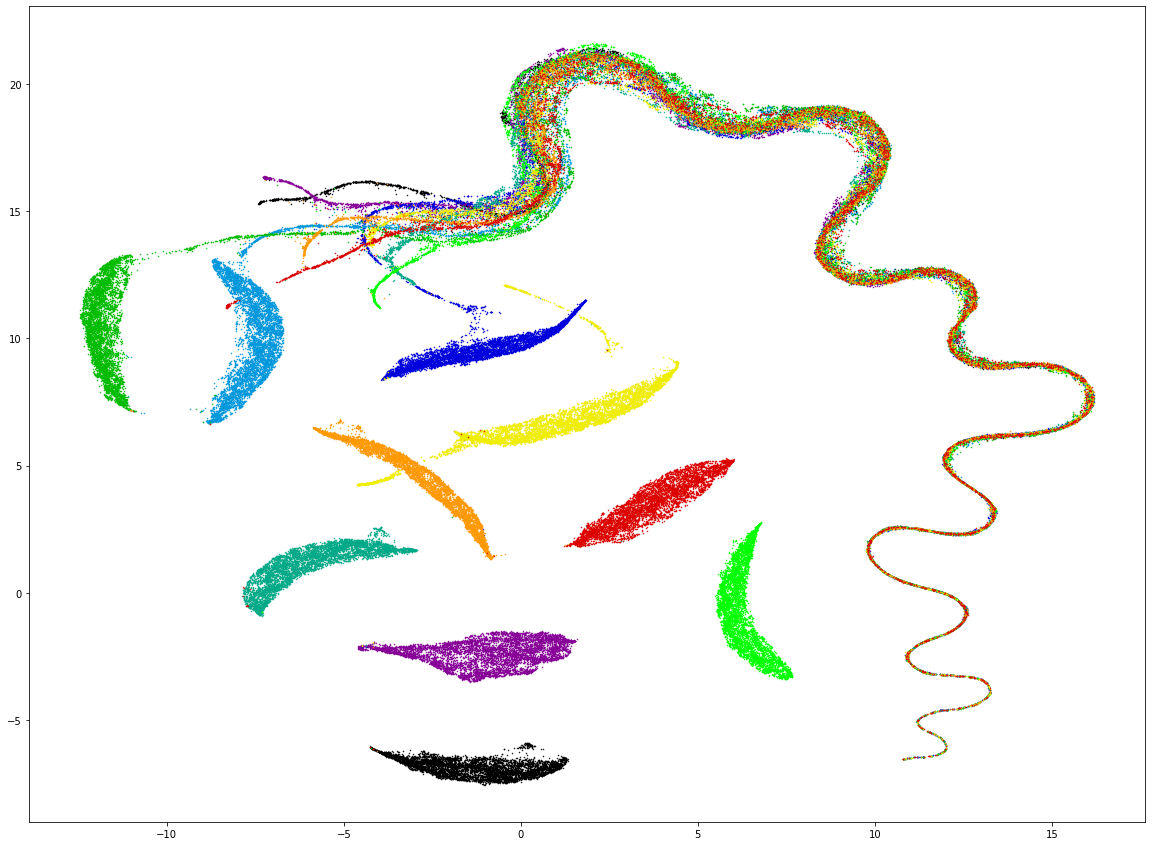

In [147]:
def plot_umap(umap_embeddings, labels):
    label_set = np.unique(labels)
    num_classes = len(label_set)
    plt.figure(figsize=(20, 15))
    plt.gca().set_prop_cycle(
        cycler(
            "color", [plt.cm.nipy_spectral(i) for i in np.linspace(0, 0.9, num_classes)]
        )
    )
    for i in range(num_classes):
        idx = labels == label_set[i]
        plt.plot(umap_embeddings[idx, 0], umap_embeddings[idx, 1], ".", markersize=1)
    plt.show()


plot_umap(transformed_features, all_labels)

unique cluster labels [0 1 2 3 4 5 6 7 8 9]
0.65100235


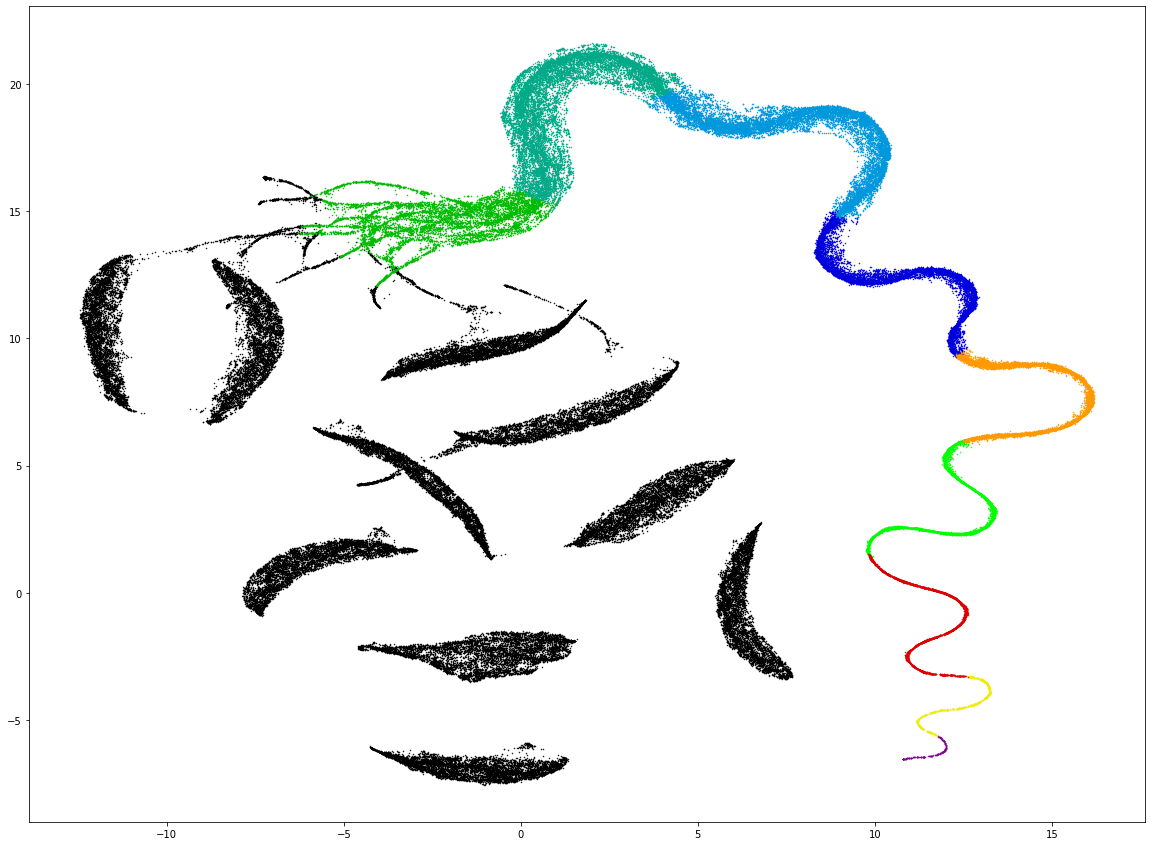

In [148]:
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_mutual_info_score, silhouette_score


# copied from https://github.com/lr94/abas/blob/master/model_selection.py
def get_centroids(data, labels, num_classes):
    centroids = np.zeros((num_classes, data.shape[1]))
    for cid in range(num_classes):
        # Since we are using pseudolabels to compute centroids, some classes might not have instances according to the
        # pseudolabels assigned by the current model. In that case .mean() would return NaN causing KMeans to fail.
        # We set to 0 the missing centroids
        if (labels == cid).any():
            centroids[cid] = data[labels == cid].mean(0)

    return centroids


centroids = get_centroids(all_features, all_labels, 10)
clustering = KMeans(n_clusters=10, init=centroids, n_init=1)
clustering.fit(all_features)
clabels = clustering.labels_
print("unique cluster labels", np.unique(clabels))
print(silhouette_score(all_features, clabels))
plot_umap(transformed_features, clabels)

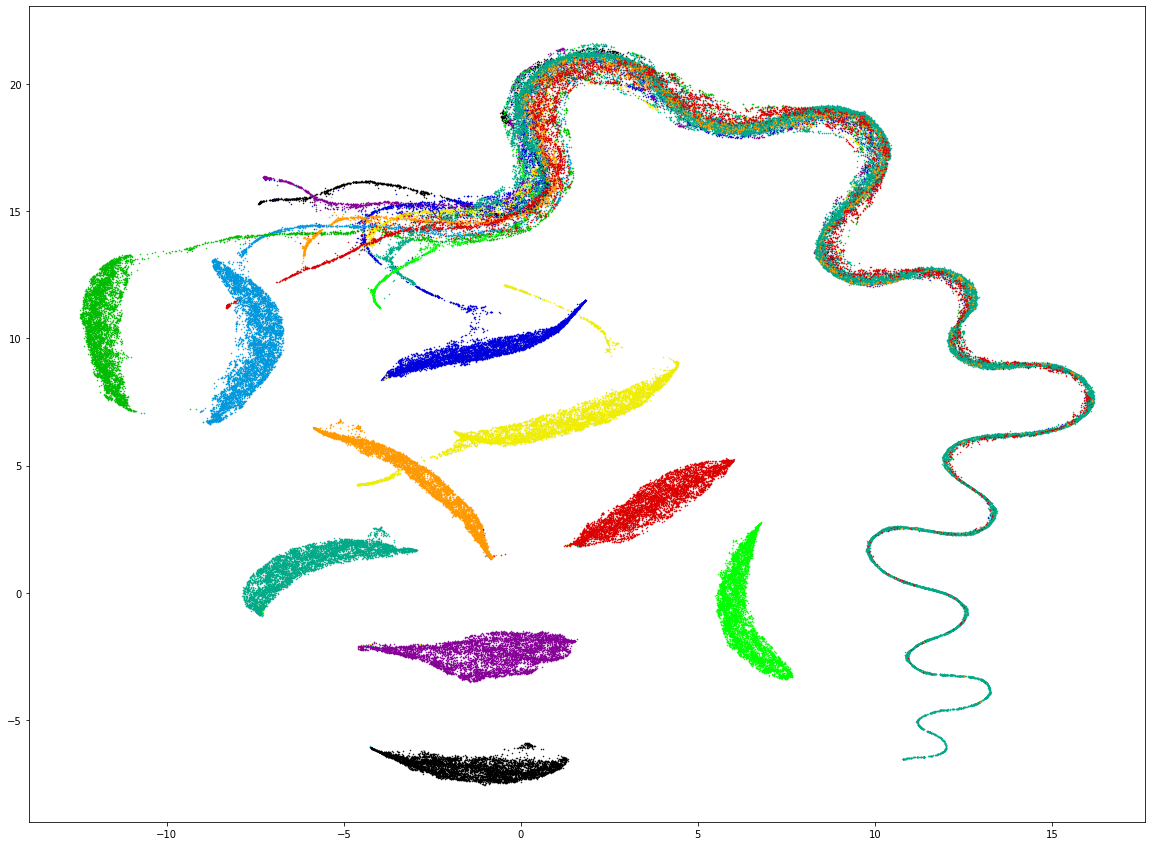

0.14671076748912867
-0.13715798


In [151]:
src_preds = np.argmax(features["45/inference/src_train/logits"], axis=1)
target_preds = np.argmax(features["45/inference/target_train/logits"], axis=1)
all_preds = np.concatenate([src_preds, target_preds], axis=0)
plot_umap(transformed_features, all_preds)
print(adjusted_mutual_info_score(all_preds, clabels))
print(silhouette_score(all_features, all_preds))